In [19]:
from matplotlib import pyplot
import datetime, matplotlib, numpy, pandas, random, scipy, seaborn

pyplot.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (15, 9)

I made a New Year's resolution that I would include uncertainty estimates in every plot I draw in 2018. So far it's holding up resonably well. But what a deep rabbit hole it is! I started with some basic knowledge of bootstrapping and confidence intervals, but I've since then had to pick up a whole arsenal of MCMC and method of moments. I'm not going to show you _how_ deep the rabbit hole, but I think there's some of it that's really neat. Either way, it's been a great way to deepen my knowledge about ~~rabbits~~ statistics, so I thought I'd share some of these tools.

I don't believe in learning things without a concrete example, so let's generate some data. We're going to generate a fake time series where the dates range from 2017-01-01 to 2017-12-31 and we have observations for each date indicating maybe an air pressure or something. I don't know, use your imagination :)

In [20]:
def generate_time_series(k=700, m=1000, n=100, start_date=datetime.date(2017, 1, 1)):
    xs = numpy.linspace(0, 1, n, endpoint=False)
    ys = [k*x + m + random.gauss(0, 500) for x in xs]
    ts = [start_date + datetime.timedelta(x)*365 for x in xs]
    return xs, ys, ts

xs, ys, ts = generate_time_series()

Before we get started with anything, we need graphics. Let's plot to see what's going on!

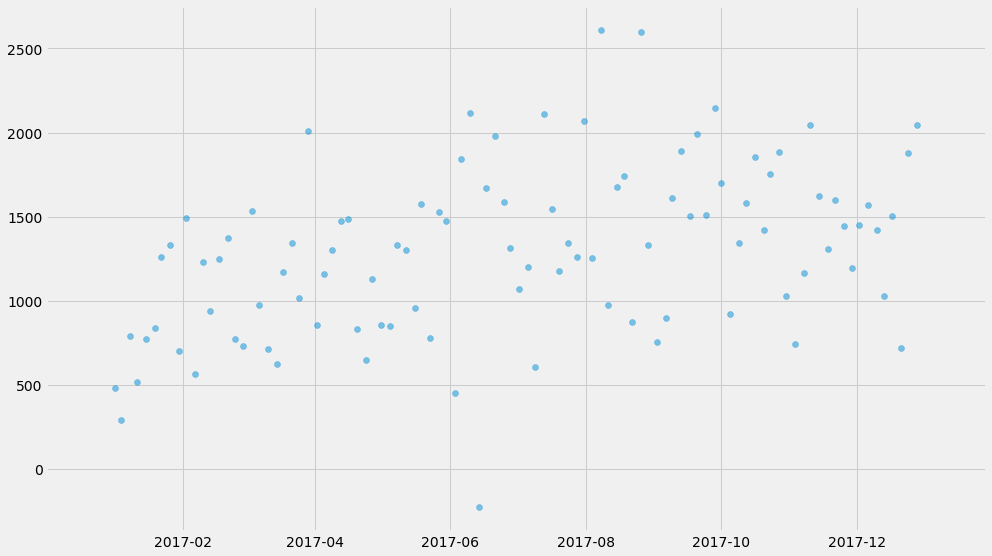

In [21]:
pyplot.scatter(ts, ys, alpha=0.5)
pyplot.show()

First of all, let's not fit any fancy models. We're just going to break it up into a few buckets and compute the mean within each bucket. But let's first pause and talk about uncertainty.

# Distribution of the data vs uncertainty

This makes me sometimes feel dumb but I keep confusing what "uncertainty" means and I think it's important to be hyper clear because we're going to do all of them. Let's say we're trying to understand quantity sold as a function of cost. There's multiple different things we can estimate the distribution for:

1. The data itself. Given a certain cost $x$, what's the distribution of outcomes in the data
2. The uncertainty of some parameter, like the parameter $k$ in a linear relationship $y = kx + m$.
3. The uncertainty of predicted quantities. So if we predict that for a cost $x$ then we're going to sell quantity $y$, we want to know the uncertainty of the quantity $y$.

Hope that makes sense! Let's start with the most basic model – just break things up in buckets. I recommend the excellent Seaborn package if we just want to get some basic idea of distributions and uncertainty estimates. Seaborn usually operates on dataframes so we're going to use that for the next few plots:

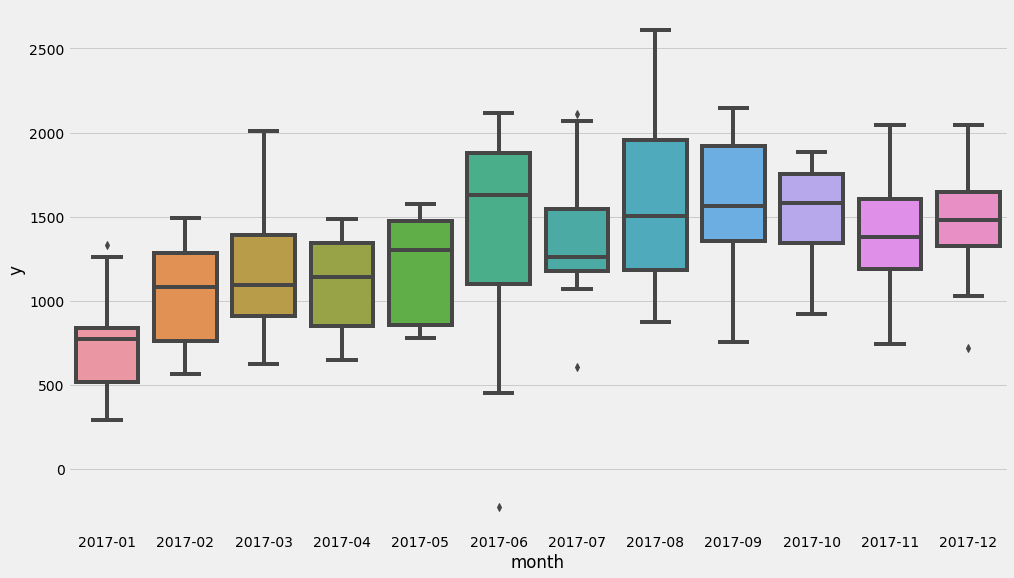

In [22]:
d = pandas.DataFrame({'x': xs, 't': ts, 'y': ys})
d['month'] = d['t'].apply(lambda t: t.strftime('%Y-%m'))
seaborn.boxplot(data=d, x='month', y='y')

Goofing around a bit with Seaborn is fun and you can use other plots like swarmplot:

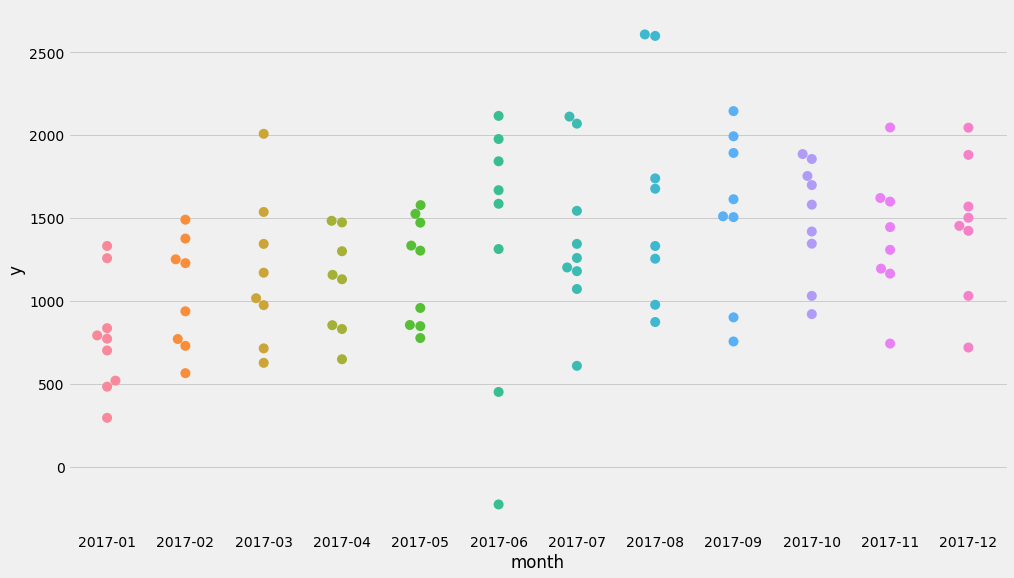

In [23]:
seaborn.swarmplot(data=d, x='month', y='y', size=10)

These last charts show the _distribution_ of the dataset.
If for whatever reason we want to compute the uncertainty of the average, turns out that Seaborn actually does that for barcharts:

/Users/erikbern/uncertainty/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


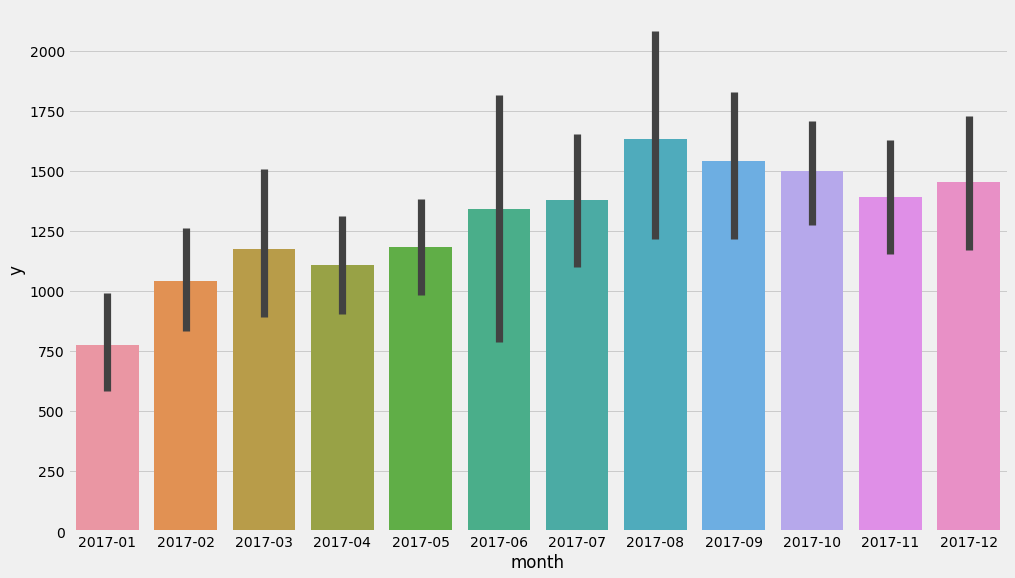

In [24]:
seaborn.barplot(data=d, x='month', y='y')

## Computing the uncertainty of the mean – normal distributions

OK! enough fooling around with Seaborn. If we actually wanted to compute the uncertainty estimates ourselves, how would we do that?

Under some mild assumptions (I'm going to get back to this in a sec and scrutinize it), we can compute the confidence intervals as:

$\bar{x} \pm 1.96\sigma / \sqrt{n}$

Where $\bar{x}$ is the mean and $\sigma$ is the standard deviation, a.k.a. the square root of the variance. I don't think this formula is super important to remember, but I think it's somewhat useful to remember that the _size of the confidence interval is inversely related to the square root of the number of samples._ For instance, this is useful when you're running an A/B test – if you want to detect a 1% difference then you need something on the order of $0.01^{-2} = 10,000$ samples. (This is a rule of thumb, don't use it for your medical device software).

Let's compute this ourselves and split it (rather than relying on Seaborn):

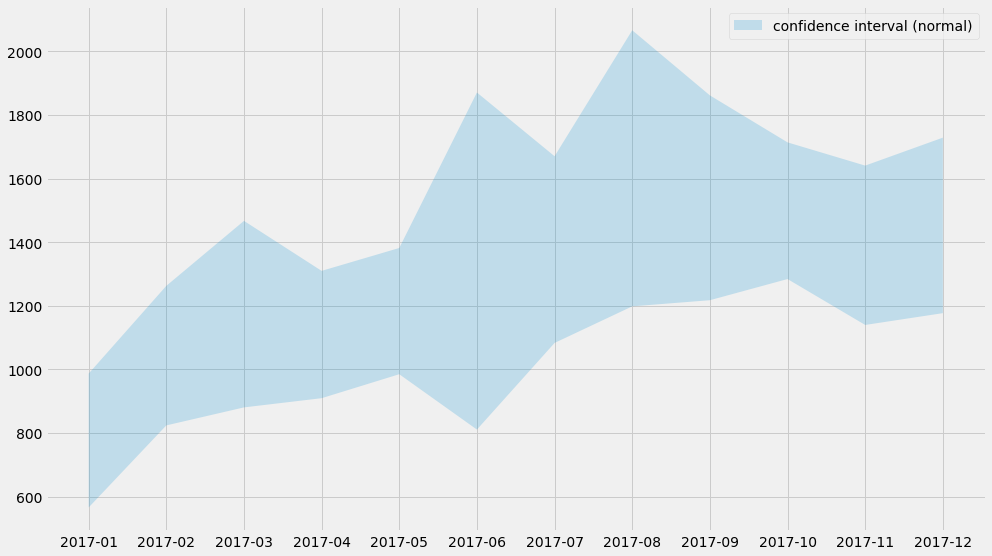

In [25]:
def plot_confidence_interval(observations_by_group):
    groups = list(sorted(observations_by_group.keys()))
    lo_bound = []
    hi_bound = []
    for group in groups:
        series = observations_by_group[group]
        mu, std, n = numpy.mean(series), numpy.std(series), len(series)
        lo_bound.append(mu - 1.96*std*n**-0.5)
        hi_bound.append(mu + 1.96*std*n**-0.5)
    pyplot.fill_between(groups, lo_bound, hi_bound, alpha=0.2, label='confidence interval (normal)')

observations_by_month = {}
for month, y in zip(d['month'], d['y']):
    observations_by_month.setdefault(month, []).append(y)
plot_confidence_interval(observations_by_month)
pyplot.legend()

I mentioned earlier that the formula for confidence interval only applies under some mild assumptions. What are those? It's the assumption of _normality_. For a large number of observations, this is nothing to worry about, and this is due to the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem).

## Computing the uncertainty for the mean – binomial distributions

There's one particular case of non-normality that I think is worth remembering. Consider the case when you're measuring something like a "conversion rate" – $k$ out of $n$ converted. Using the "off the shelf" formula for confidence intervals, you might get weird ones that go below 0% or above 100%. The confidence interval of a "$k$ out of $n$" scenario is much better handled using a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution). I've personally benefitted from memorizing the formula for the confidence interval and think I probably use it more than the previous (Normal based) one. In particular all you need to remember is

In [26]:
n, k = 100, 3
scipy.stats.beta.ppf([0.05, 0.95], k, n-k)

array([0.00830942, 0.0622281 ])

This will compute a 90% confidence interval if you plug in values for $n$ and $k$. In this case we see that if we have 100 website visitors and 3 of them purchased the product, then the 90% uncertainty estimate is 0.8%-6.2%. We can try this for a more realistic dataset:

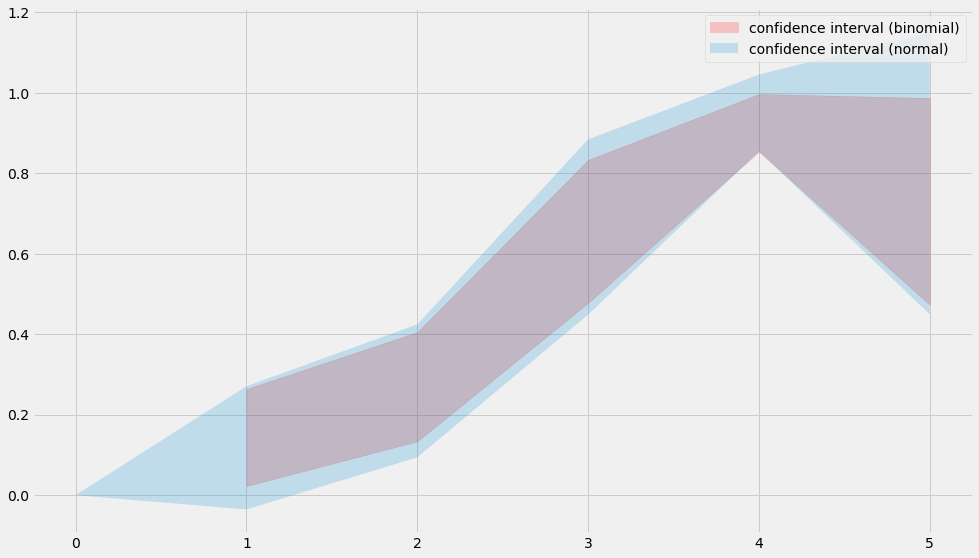

In [28]:
from scipy.special import expit  # sigmoid

def bernoulli(z):
    return float(random.random() < z)

def generate_logistic_data(k=2, m=-5, n=100):
    xs = [random.random()*5 for _ in range(n)]
    ys = [bernoulli(expit(k*x + m)) for x in xs]
    return xs, ys

def plot_binomial_confidence_interval(observations_by_group):
    groups = list(sorted(observations_by_group.keys()))
    lo_bound = []
    hi_bound = []
    for group in groups:
        series = observations_by_group[group]
        n, k = len(series), sum(series)
        lo_bound.append(scipy.stats.beta.ppf(0.05, k, n-k))
        hi_bound.append(scipy.stats.beta.ppf(0.95, k, n-k))
    pyplot.fill_between(groups, lo_bound, hi_bound, alpha=0.2, label='confidence interval (binomial)', color='red')

xs, ys = generate_logistic_data()
observations_by_integer_x = {}
for x, y in zip(xs, ys):
    observations_by_integer_x.setdefault(round(x), []).append(y)
plot_binomial_confidence_interval(observations_by_integer_x)
plot_confidence_interval(observations_by_integer_x)
pyplot.legend()

The binomial confidence interval has the benefit that it's slightly tighter and also always confined between 0 and 1, which is nice. Apparently there's a whole [Wikipedia page](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) featuring a gazillion ways to compute this, so it's not like my method here is the golden truth.


## Bootstrapping

Another approach that can be useful is bootstrapping. It allows you do compute the same statistics without memorizing any formulas. The idea is to compute the mean, but do it for $n$ _bootstraps_, where each bootstrap is a random sample (with replacement) from our observations. For every bootstrap, we compute a mean, and then we take the mean in the 95th and the 5th percentile as the confidence interval:

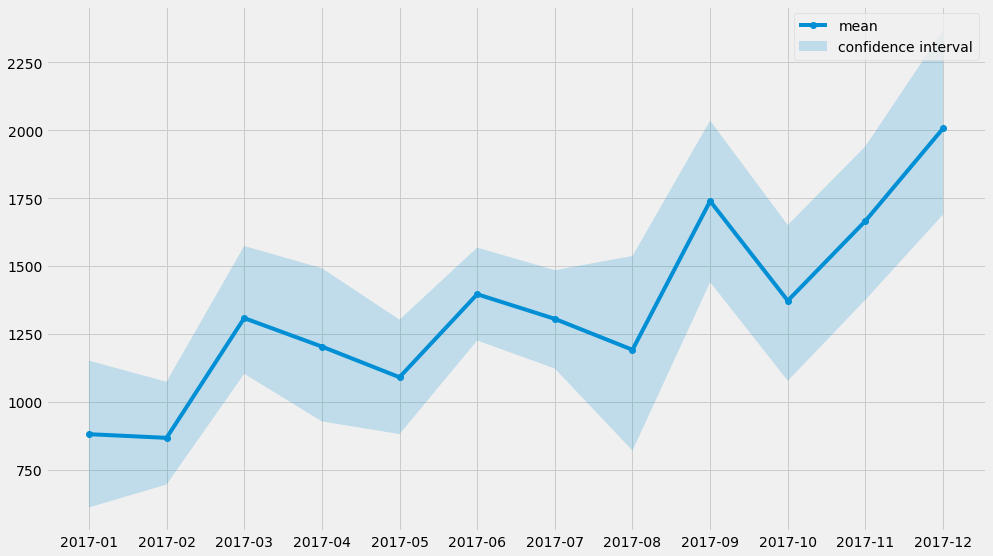

In [136]:
lo_bound = []
hi_bound = []
mean = []
for month in months:
    series = observations_by_month[month]
    bootstrapped_means = []
    for i in range(1000):
        bootstrap = [random.choice(series) for _ in series]  # sample with replacement
        bootstrapped_means.append(numpy.mean(bootstrap))
    mean.append(numpy.mean(series))
    lo_bound.append(numpy.percentile(bootstrapped_means, 5))
    hi_bound.append(numpy.percentile(bootstrapped_means, 95))
pyplot.clf()
pyplot.plot(months, mean, marker='o', label='mean')
pyplot.fill_between(months, lo_bound, hi_bound, alpha=0.2, label='confidence interval')
pyplot.legend()

Miraculously, this charts look very similar to the previous one! Just kidding – that was sort of expected :)

Bootstrapping is nice because it lets you dodge any questions about what probability distribution the data is generated from. It's basically plug and play, and works on almost everything, thought it can be a bit slow.

Be aware though that there's a *danger zone* of bootstrapping. My understanding is that bootstrapping will _converge_ towards the correct estimates as the number of samples goes to infinity, but if you're working with small samples, you can get really wonky results. I generally never trust bootstrapping for anything less than say 50 samples, and neither should you.

# Regression

Let's crank it up a notch. We're going to fit a linear regression to this bad boy.

There's some smart ways you can implement linear regression so that it's extremely fast, but I think it clouds the argument a bit. I'm going to do it in what I think of as the most general possible way. We're going to define a _model_ (in this case a straight line), a _loss function_ (squared deviations from this straight line) and then optimize it using a general-purpose solver (scipy.optimize.minimize).

No handles with labels found to put in legend.


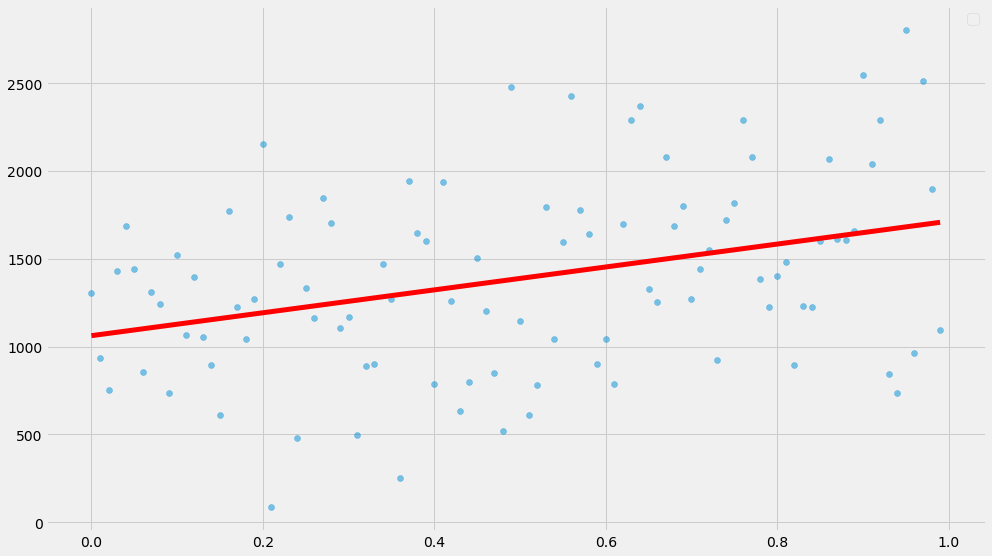

In [30]:
xs, ys, ts = generate_time_series()

def model(xs, k, m):
    return k * xs + m

def l2_loss(tup, xs, ys):
    k, m = tup
    delta = model(xs, k, m) - ys
    return numpy.dot(delta, delta)

k_hat, m_hat = scipy.optimize.minimize(l2_loss, (0, 0), args=(xs, ys)).x
pyplot.scatter(xs, ys, alpha=0.5)
pyplot.plot(xs, model(xs, k_hat, m_hat), color='red', linewidth=5)
pyplot.legend()

## Linear regression with uncertainty

We just fit $k$ and $m$ but there's no uncertainty estimates here. There's several things we could estimate uncertainties for, but let's start with the _uncertainty of the predicted values_.

We can do that by fitting a normal distribution around the line _at the same time_ as we're fitting $k$ and $m$. I'm going to do this using [Maximum Likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). It turns out the function we just minimized (the squared loss) is the negative log likelihood of a normal distribution with a fixed variance. If we make the variance an unknown variable $\sigma^2$ we can fit that at the same time! The quantity we're going to try to minimize now turns into

$ \frac{n}{2}\log{2\pi\sigma^2} + \frac{1}{2\sigma^2}\sum \left(y_i - \hat{y_i}\right)^2 $

Where $\hat{y_i} = kx_i + m$ are the predicted values by our model. Let's try to fit that!

No handles with labels found to put in legend.


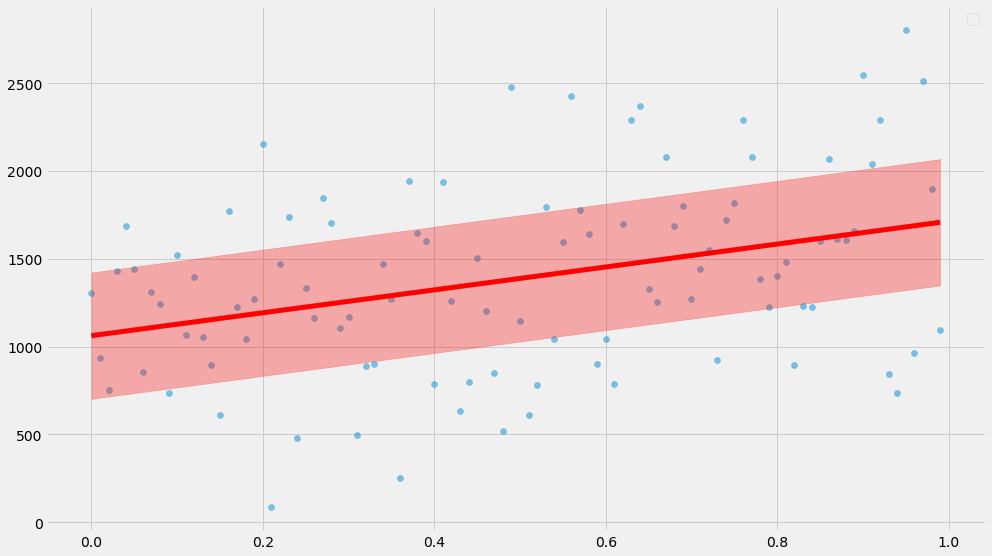

In [31]:
import scipy.optimize

def neg_log_likelihood(tup, xs, ys):
    k, m, sigma = tup
    delta = k * xs + m - ys
    return len(xs)*numpy.log(2*numpy.pi*sigma**2) + numpy.dot(delta, delta) / (2*sigma**2)

k_hat, m_hat, sigma_hat = scipy.optimize.minimize(neg_log_likelihood, (0, 0, 1), args=(xs, ys)).x
pyplot.scatter(xs, ys, alpha=0.5)
pyplot.plot(xs, xs*k_hat + m_hat, color='red', linewidth=5)
pyplot.fill_between(xs, xs*k_hat + m_hat - sigma_hat, xs*k_hat + m_hat + sigma_hat, color='red', alpha=0.3)
pyplot.legend()

We're fitting a _constant_ uncertainty here, but you could imagine making the uncertainty itself vary, fitting a more complex model. But let's switch topic for a bit.

# Bootstrapping, again

So let's take it to the next level and try to estimate the uncertainty estimate of $k$ and $m$! I like bootstrapping here because it's basically cookie cutter – we don't need to know any formula for it (side note: turns out there _is_ a formulate for it, but it's something complex with a [hyperbolic shape](https://en.wikipedia.org/wiki/Simple_linear_regression#Normality_assumption)... either way I think at this point it's almost useless to try to memorize).

So let's use bootstrap. For every bootstrap estimate, I'm going to draw a line. We can also take all those lines and compute a confidence interval:

/Users/erikbern/uncertainty/env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


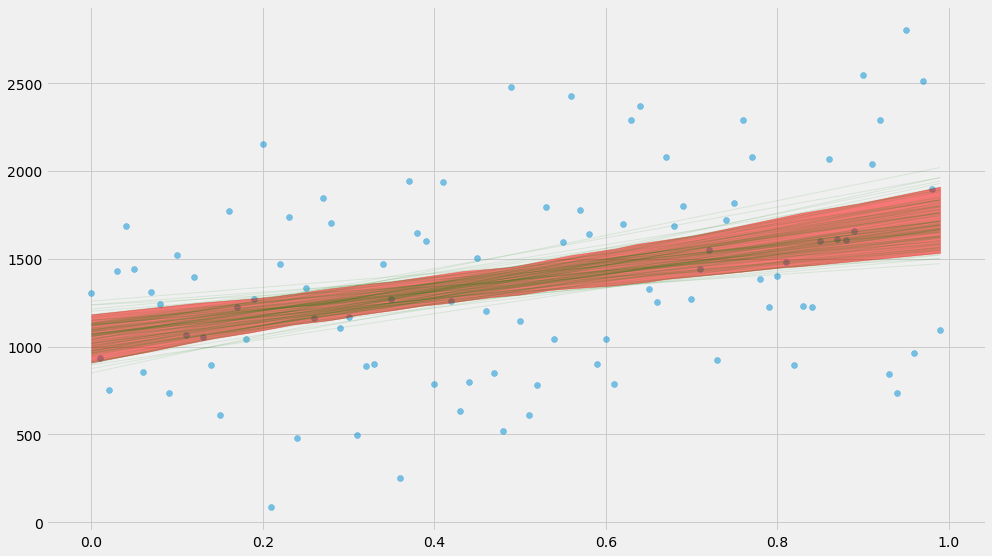

In [38]:
pyplot.scatter(xs, ys, alpha=0.5)
xys = list(zip(xs, ys))
x_scale = numpy.linspace(min(xs), max(xs), 1000)
curves = []
for i in range(100):
    bootstrap = [random.choice(xys) for _ in xys]  # sample with replacement
    xs_bootstrap = numpy.array([x for x, y in bootstrap])
    ys_bootstrap = numpy.array([y for x, y in bootstrap])
    k_hat, m_hat = scipy.optimize.minimize(l2_loss, (0, 0), args=(xs_bootstrap, ys_bootstrap)).x
    curves.append(x_scale*k_hat + m_hat)

# Plot individual lines
for curve in curves:
    pyplot.plot(x_scale, curve, alpha=0.1, linewidth=1, color='green')

# Plot 90% confidence interval
lo, hi = numpy.percentile(curves, (5, 95), axis=0)
pyplot.fill_between(x_scale, lo, hi, color='red', alpha=0.5)


Whoa, what's going on here? This uncertainty is _very_ different from the earlier plot. This seems confusing until you realize that they show two very different things:

* The first plot finds _one_ solution of $k$ and $m$ and shows the uncertainty of the _predictions._ So, if you're asked what's the range of air pressure in the next month, you can get it from the chart.
* The second plot finds _many_ solutions of $k$ and $m$, and shows the uncertainty of $kx + m$. So this answers a different question – what's the trend of air pressure over time and what's the uncertainty _of the trend_.

I guess in theory we could combine the two approaches and make it even more complicated by fitting many different $k$ and $m$ and showing the uncertainty of $y$. Your head might be spinning, but I'm just pointing out that there can be many different things we might want.

## What about bootstrap for logistic regression?

It should be added that one of the beauties of this method is that it extends to almost anything you're trying to fit. We can easily do the same thing for a logistic regression model:

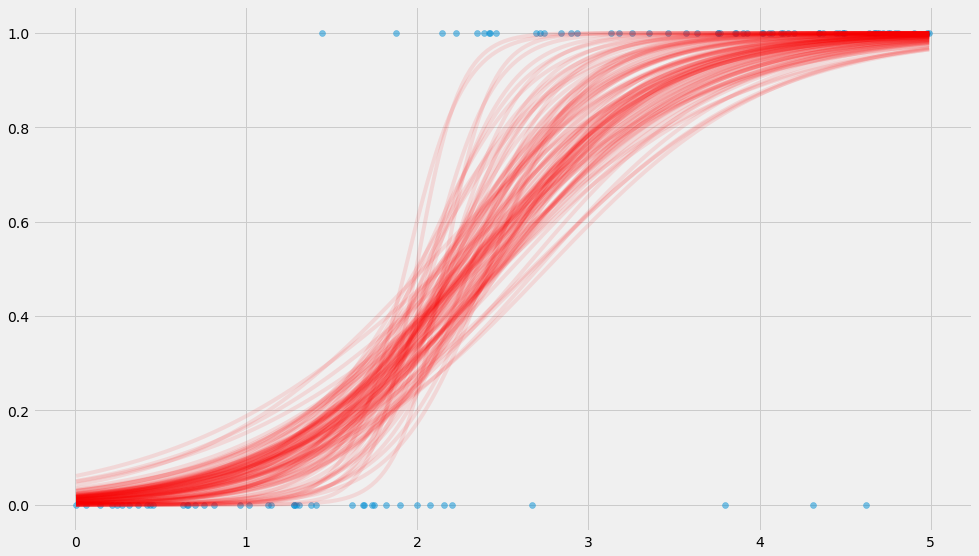

In [153]:
xs, ys = generate_logistic_data()

def logistic_loss(tup, xs, ys):
    k, m = tup
    y_hat = 1 / (1 + numpy.exp(-k*xs - m))
    eps = 1e-9  # to prevent log(0) – can also be avoided by implementing log(sigmoid(z)) manually
    return -numpy.dot(ys, numpy.log(y_hat+eps)) + -numpy.dot(1-ys, numpy.log(1-y_hat+eps))

pyplot.scatter(xs, ys, alpha=0.5)

xys = list(zip(xs, ys))
xs_hat = numpy.linspace(min(xs), max(xs), 200)
for i in range(100):
    bootstrap = [random.choice(xys) for _ in xys]  # sample with replacement
    xs_bootstrap = numpy.array([x for x, y in bootstrap])
    ys_bootstrap = numpy.array([y for x, y in bootstrap])
    k_hat, m_hat = scipy.optimize.minimize(logistic_loss, (0, 0), args=(xs_bootstrap, ys_bootstrap)).x
    pyplot.plot(xs_hat, 1/(1+numpy.exp(-(k_hat * xs_hat + m_hat))), alpha=0.1, color='red')

# Markov chain Monte Carlo methods

It's going to get a bit wilder now. I'm going to switch to some Bayesian methods, where we estimate $k$ and $m$ by drawing samples.  For this, we're going to use a library called [emcee](http://emcee.readthedocs.io/) which I've found pretty easy to use compared to all the ones I've tried so far. All it needs is a log-likelihood function, which as it turns out we just defined earlier! We just need to take the _negative_ of it.

In [150]:
import emcee
xs, ys, ts = generate_time_series()

def log_likelihood(tup, xs, ys):
    return -neg_log_likelihood(tup, xs, ys)

ndim, nwalkers = 3, 10
p0 = [numpy.random.rand(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[xs, ys])
sampler.run_mcmc(p0, 5000)
samples = sampler.chain[:, -10:, :].reshape((-1, ndim))  # Grab the last 10 from each walker

Let's plot the sampled values for $k$ and $m$!

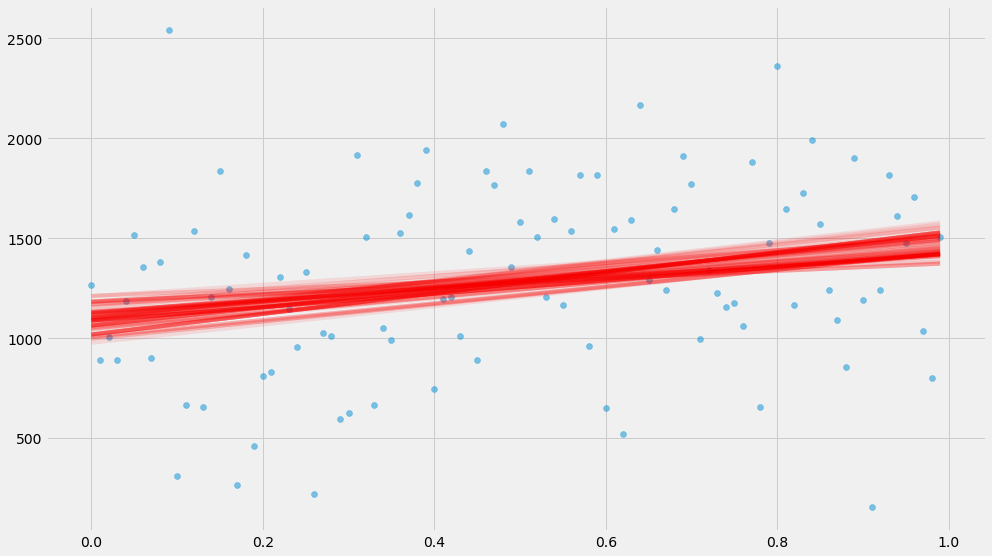

In [151]:
x_scale = numpy.linspace(min(xs), max(xs), 1000)
curves = []
pyplot.scatter(xs, ys, alpha=0.5)
for k, m, sigma in samples:
    pyplot.plot(x_scale, k*x_scale + m, alpha=0.1, color='red')

There's a bit more stuff that goes into these methods – the sampling is a bit finicky and requires a bit of handholding to get to work well. I don't want to get into all the specifics, and I'm a layman myself. But it can often be several orders of magnitude faster than booststrapping.

As a side note, we end up with samples from the posterior distribution of $k, m, \sigma$. We can look at the probability distribution of these guys. For instance, here's the distribution of $\sigma$:

/Users/erikbern/uncertainty/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


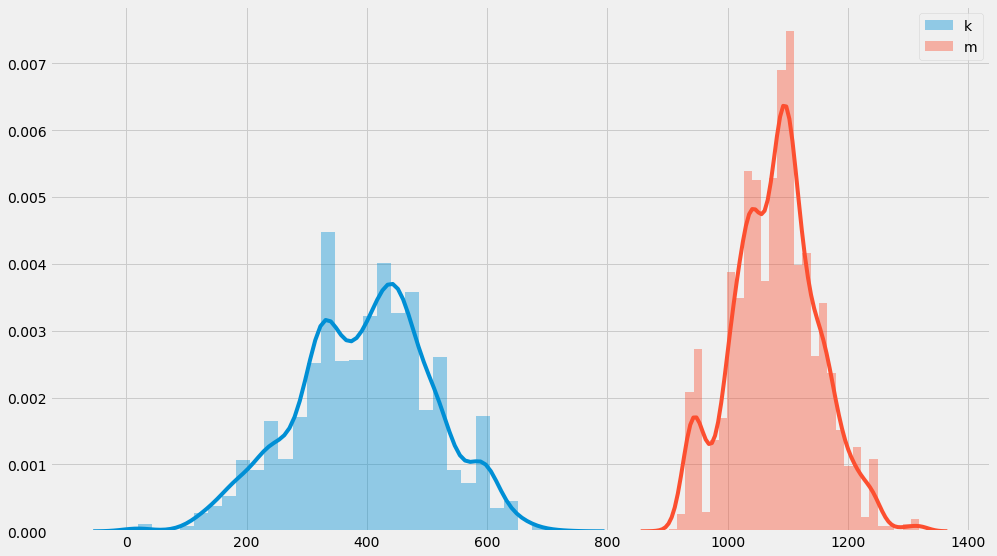

In [152]:
samples = sampler.chain[:, -200:, :].reshape((-1, ndim)) # Grab slightly more samples
seaborn.distplot([k for k, m, sigma in samples], label='k')
seaborn.distplot([m for k, m, sigma in samples], label='m')
pyplot.legend()

You can see that these distribution center around $k=500$ and $m=1000$ which is how we constructed them in the first place. That's somewhat reassuring!

These Bayesian methods don't end here. In particular there's several libraries that work with these kind of problems. It turns out that if you express the problem in a more structured way (not just a negative log-likelihood function), you can make the sampling scale to large problems (as in, thousands of unknown parameters). For Python there's [PyMC3](https://docs.pymc.io/) and [PyStan](http://pystan.readthedocs.io/en/latest/), as well as the slightly more experimental (?) [Edward](http://edwardlib.org/) and [Pyro](http://pyro.ai/).